In [1]:
%config Completer.use_jedi = False
import numpy as np


In [2]:
grid = np.zeros((18,18))
grid[5,7] = 1
grid[4,8] = 2
grid[3,9] = 3

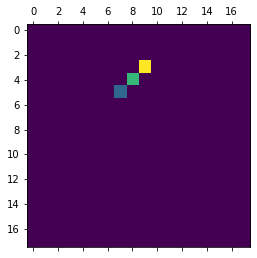

In [3]:
import matplotlib.pyplot as plt
plt.matshow(grid)

In [ ]:
import rospy as rp
from sensor_msgs.msg import LaserScan
from nav_msgs.msg import Odometry
rp.init_node('runner')

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


In [3]:
import time

sc = None

def setSc(x):
    global sc
    sc = x.ranges
    
odom = None

def setOdom(o):
    global odom
    odom = o

scans = rp.Subscriber("/scan",LaserScan,setSc)
os = rp.Subscriber("/odom",Odometry,setOdom)

while sc == None:
    time.sleep(1)

scans.unregister()
os.unregister()

In [60]:
sc = [-np.inf]*360

In [96]:
fidelty = 10

pos = np.array([1.5*fidelty,1.5*fidelty]).astype(np.int)
grid = np.ones((6*fidelty,6*fidelty))
goal = np.array([4.*fidelty,3.2*fidelty]).astype(np.int)
grid[pos[0],pos[1]] = -5
grid[goal[0],goal[1]] = -10
#grid[4,8] = 2
#grid[3,9] = 3

offset = 0#int(get_rotation(odom))-90

for alpha in range(len(sc)):    
    c = sc[alpha]
    
    rad = np.deg2rad((alpha+offset)%360)
    
    if np.abs(c) == np.inf:
        continue
    
    a = (c * np.sin(rad))*fidelty
    b = (c * np.cos(rad))*fidelty
    
    idx = (pos-np.array([b,a])).astype(np.int)
    
   # print(idx)
        
    grid[idx[0],idx[1]] = 10
    #print(idx.astype(np.int))

In [113]:
grid[25,:35] = 10
a = 25
b = 35

for i in range(10):
    grid[a-i-1,b+i] = 10
    grid[a-i,b+i] = 10

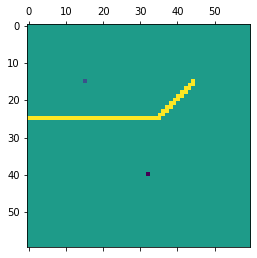

In [114]:
import matplotlib.pyplot as plt
plt.matshow(grid)

In [1]:
def dist(x,y,a,b):
    #print(s)
    return np.sqrt((x-a)**2+(b-y)**2)


def h(p):
    return dist(p[0],p[1],goal[0],goal[1])

def heuristic(x,y):
    return dist(x,y,goal[0],goal[1])

def cost(x,y):
    return dist(x,y,goal[0],goal[1])#dist(x,y,pos[0],pos[1])#*grid[x,y]

In [2]:
field = np.zeros((6*fidelty,6*fidelty))

NameError: name 'np' is not defined

In [3]:
for i in range(6*fidelty):
    for j in range(6*fidelty):
        val = cost(i,j)+heuristic(i,j)
        field[i,j] = val

NameError: name 'fidelty' is not defined

In [4]:
plt.matshow(field, cmap='jet')

NameError: name 'plt' is not defined

In [119]:
x_max = 6*fidelty-1
y_max = 6*fidelty-1

class Node:
    nodes = {}
    
    def __init__(self,x,y,parent):
        self.x = x
        self.y = y
        
        self.parent = parent
        
        self.h = self.heuristic()
        if parent:
            self.g = parent.g + self.cost()
        else:
            self.g = self.cost()
            
        self.f = self.h+self.g
        
        if not self in Node.nodes:
            Node.nodes[self] = self
        else if self.f < Node.nodes[self].f:
            Node.nodes[self] = self
        
    def cost(self):
        if self.parent:
            return Node.nodes[parent].cost() + dist(self.x,self.y,self.parent.x,self.parent.y)
        else:
            return 1
    
    def heuristic(self):
        return dist(self.x,self.y,goal[0],goal[1]) 
            
    def getChildren(self,k=1):
        if self.x == 0 or self.y == 0 or self.x == x_max-1 or self.y == y_max-1:
            return [Node(*n) for n in [
                (self.x+1,self.y,self),
                (self.x,self.y+1,self),
                (self.x-1,self.y,self),
                (self.x,self.y-1,self),
                (self.x+1,self.y+1,self),
                (self.x-1,self.y-1,self),
                (self.x-1,self.y+1,self),
                (self.x+1,self.y-1,self),
            ] if n[0] >= 0 and n[0] < x_max and n[1] >= 0 and n[1] < y_max]
        
        else:
            return [
                Node(self.x+1,self.y,self),
                Node(self.x,self.y+1,self),
                Node(self.x,self.y-1,self),
                Node(self.x-1,self.y,self),
                Node(self.x+1,self.y+1,self),
                Node(self.x-1,self.y-1,self),
                Node(self.x-1,self.y+1,self),
                Node(self.x+1,self.y-1,self),
            ]
    
    def getPath(self):
        if self.parent:
            return [self]+self.parent.getPath()
        
        return [self]
        
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
        
    def __repr__(self):
        return self.__str__()
   
    def __str__(self):
        return "({},{})".format(self.x,self.y)
    
    def __hash__(self):
        return int(self.x+self.y*fidelty)

In [ ]:
def 

In [306]:
from time import time

def k():
    start = Node(pos[0],pos[1],None)
    goal_node = Node(goal[0],goal[1],None)
    (xDim,yDim) = np.where(grid==10)
    obstacles = list(zip(xDim,yDim))
    closed_list = [Node(i[0],i[1],None) for i in obstacles]

    too_close = []

    for n in closed_list:
        too_close += n.getChildren()

    closed_list = (closed_list+too_close)

    closed_list += [start]
    closed_list = set(closed_list)
    open_list = set(start.getChildren())

    i = 0
    
    while len(open_list) > 0:
        current = min(open_list,key=lambda x:x.f)
        #i += 1

        #print(i)

        if current == goal_node:
            print("found")
            break

        children = current.getChildren()
        c_set = set(children)
        c_out = c_set.difference(closed_list)
        c_in = c_out.intersection(open_list)#.difference(closed_list)
        o_in =  open_list.intersection(c_set)

        for c in c_out:            
            open_list.add(c)

        for c in c_in:
            o = None
            for x in o_in:
                if x == c:
                    o = c
                    break

            if c.f < o.f:
                open_list.remove(o)
                open_list.add(c)
               
        closed_list.add(current)
        open_list.remove(current)
        
    print(len(closed_list))
        
    return current
        
s = time()
current = k()
time()-s
#current,open_list

found
1235


0.14055442810058594

In [121]:
result = np.copy(grid)

for node in current.getPath():
    result[node.x,node.y] = 5
    

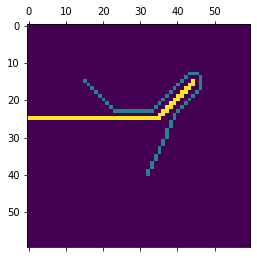

In [122]:
plt.matshow(result)

In [295]:
x_max = 6*fidelty-1
y_max = 6*fidelty-1

def getChildren(p):
    x,y = p
    if x == 0 or y == 0 or x == x_max or y == y_max:
        return [n for n in [
            (x+1,y),
            (x,y+1),
            (x-1,y),
            (x,y-1),
            (x+1,y+1),
            (x-1,y-1),
            (x-1,y+1),
            (x+1,y-1),
        ] if n[0] >= 0 and n[0] < x_max and n[1] >= 0 and n[1] < y_max]

    else:
        return [
             (x+1,y),
            (x,y+1),
            (x-1,y),
            (x,y-1),
            (x+1,y+1),
            (x-1,y-1),
            (x-1,y+1),
            (x+1,y-1)
        ]


In [296]:
(xDim,yDim) = np.where(grid==10)
obstacles = np.column_stack([xDim,yDim])

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R
fidelty = 10
goal = None
pos = None
grid = np.ones((6*fidelty,6*fidelty))

x_max = 6*fidelty-1
y_max = 6*fidelty-1

g_values = np.ndarray((6*fidelty,6*fidelty))
f_values = np.ndarray((6*fidelty,6*fidelty))
closed_list = np.ndarray((6*fidelty,6*fidelty),dtype=np.bool)
parents = np.ndarray((6*fidelty,6*fidelty),dtype=object)

def dist(x,y,a,b):
    return np.sqrt((x-a)**2+(b-y)**2)

def get_rotation (odom):
    orientation_q = odom.pose.pose.orientation
    r = R.from_quat([orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w])
    return r.as_euler(seq="xyz",degrees=True)[-1]

def setGoal(x,y):
    global goal
    
    if goal is not None:
        grid[goal[0],goal[1]] = 1
    
    goal = np.array([y*fidelty,x*fidelty]).astype(np.int)
    grid[goal[0],goal[1]] = -10

def updateGrid(x,y,odom,scans):
    global grid
    global pos 
    global goal
        
    if pos is not None:
        grid[pos[0],pos[1]] = 1
        
    pos = np.array([y*fidelty,x*fidelty]).astype(np.int)
    grid[pos[0],pos[1]] = 0

    offset = int(get_rotation(odom))-90

    for alpha in range(len(scans)):    
        c = scans[alpha]

        rad = np.deg2rad((alpha+offset)%360)

        if np.abs(c) == np.inf:
            continue

        a = (c * np.sin(rad))*fidelty
        b = (c * np.cos(rad))*fidelty

        idx = (pos-np.array([b,a])).astype(np.int)

       # print(idx)

        grid[idx[0],idx[1]] = 10
        
def heuristic(p):
    return dist(*p,*goal)*0.1

def getChildren(p):
    x,y = p
    if x == 0 or y == 0 or x == x_max or y == y_max:
        return [n for n in [
            (x+1,y),
            (x,y+1),
            (x-1,y),
            (x,y-1),
            (x+1,y+1),
            (x-1,y-1),
            (x-1,y+1),
            (x+1,y-1),
        ] if n[0] >= 0 and n[0] < x_max and n[1] >= 0 and n[1] < y_max]

    else:
        return [
             (x+1,y),
            (x,y+1),
            (x-1,y),
            (x,y-1),
            (x+1,y+1),
            (x-1,y-1),
            (x-1,y+1),
            (x+1,y-1)
        ]
    
def getPath(start,end):
    global goal
    global parents
    
    path = []
    c = end

    while c != start:
        p = parents[c]
        
        if p == None:
            return None
        
        path.append(p)
        c = p
        
    return path
        
def getRoute(fake_obstacles=[],distance=2):
    global grid
    global pos
    global goal
    global g_values
    global f_values
    global parents
    global closed_list
    
    start = (pos[0],pos[1])
    goal = (goal[0],goal[1])
    (xDim,yDim) = np.where(grid==10)
    obstacles = np.concatenate([np.column_stack([xDim,yDim]),fake_obstacles])
    
    too_close = []

    for i in range(distance):
        for n in obstacles:
            too_close += getChildren(n)

        obstacles = np.unique(np.concatenate([obstacles,too_close]),axis=0)
        
    g_values[:,:] = np.inf
    f_values[:,:] = np.inf
    parents[:,:] = None
    closed_list[:,:] = False

    g_values[start] = 0
    f_values[start] = heuristic(start)
    closed_list[obstacles[:,0],obstacles[:,1]] = True
    
    open_list = [start]
    
    while len(open_list) > 0:
        i = np.argmin([f_values[x] for x in open_list])
        current = open_list[i]

        del open_list[i]
        closed_list[current] = True

        if current == goal:
            break

        children = getChildren(current)

        g_parent = g_values[current]

        for c in children:
            if not closed_list[c]:
                g = g_parent + dist(*c,*current)
                if g < g_values[c]:
                    parents[c] = current
                    g_values[c] = g
                    f_values[c] = g + heuristic(c)

                    if c not in open_list:
                        open_list.append(c)

    return getPath(start,goal)#,open_list,closed_list

In [297]:
too_close = []
for i in range(2):
    for n in obstacles:
        too_close += getChildren(n)

    obstacles = np.unique(np.concatenate([obstacles,too_close]),axis=0)

In [298]:
closed_list[obstacles[:,0],obstacles[:,1]] = True

In [299]:
g_values = np.ndarray((6*fidelty,6*fidelty))
g_values[:,:] = np.inf

f_values = np.copy(g_values)
closed_list = np.ndarray((6*fidelty,6*fidelty),dtype=np.bool)
parents = np.ndarray((6*fidelty,6*fidelty),dtype=object)

In [300]:
start = (pos[0],pos[1])
goal = (goal[0],goal[1])

In [301]:
open_list = [start]
open_list

[(15, 15)]

In [302]:
def h(p):
    #return dist(p[0],p[1],goal[0],goal[1])
    return abs(p[0]-goal[0])+abs(p[1]-goal[1])

In [307]:
s = time()

g_values[:,:] = np.inf
f_values[:,:] = np.inf
parents[:,:] = None
closed_list[:,:] = False

g_values[start] = 0
f_values[start] = h(start)
closed_list[obstacles[:,0],obstacles[:,1]] = True

open_list = [start]
while len(open_list) > 0:
    i = np.argmin([f_values[x] for x in open_list])
    current = open_list[i]
    
    del open_list[i]
    
    if current == goal:
        break
        
    children = getChildren(current)
    
    g_parent = g_values[current]
    
    for c in children:
        if not closed_list[c]:
            g = g_parent + dist(*c,*current)
            if g < g_values[c]:
                parents[c] = current
                g_values[c] = g
                f_values[c] = g + h(c)

                if c not in open_list:
                    open_list.append(c)

time()-s

0.06972050666809082

In [304]:
path = []

c = goal

while c != start:
    p = parents[c]
    path.append(p)
    c = p

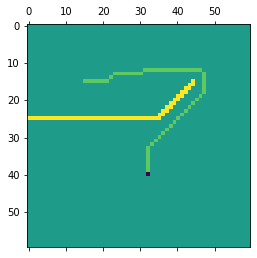

In [305]:
result = np.copy(grid)

for node in path:
    result[node] = 5
    
plt.matshow(result)